# Backtesting the Buy Close - Sell Open (BSCO) Strategy on the S&P500

This strategy involves buying at close and selling at open. I think the logic behind it is that more people will buy at open and sell at close - so by going against the grain you are taking advantage of the purchase behavior of others.

I will compare it to a simple buy and hold strategy over the same period of time.

In [131]:
# First loading in necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [132]:
# I am using historical data from yahoo finance going back to 1993 - as far back as the data goes
df = pd.read_csv("SPY.csv")

In [133]:
# The only three columns needed here are the Opening price and the Closing price
df = df[['Open','Close']]

In [240]:
# Checking the top few rows of the DataFrame to make sure everything is in order
df.head()
# And creating separate dataframes so results are not confounded
df_BCSO = df.copy()
df_BH = df.copy()

### Necessary functions
There are four necessary functions - a function to buy stock, a function to sell stock, a function to test the BCSO strategy, and a function to test the buy and hold strategy.

In [135]:
# BUY STOCK FUNCTION
# Input the stock price and the amount of capital invested
# Returns the number of shares bought and the money spent on those shares

def buy_stock(stock_price,capital):
    num_shares = capital//stock_price
    invested_cap = num_shares*stock_price
    return int(num_shares),round(invested_cap,2)

In [136]:
# SELL STOCK FUNCTION
# Input the stock price and the number of shares sold
# Returns the amount of money made

def sell_stock(stock_price,num_shares):
    return_cap = stock_price * num_shares
    return return_cap


In [137]:
# BCSO STRATEGY FUNCTION
# Input the dataframe of Open/Close prices, and the amount of money initially invested
# Returns dataframe with daily return as a third column

def BCSO_strategy(df,starting_cap):
    fund = starting_cap
    lst = []
    lst.append(fund)
    for i in range(0,len(df.index)-1):
        num_shares, investment = buy_stock(df['Close'][i],fund)
        fund = fund - investment
        sale = sell_stock(df['Open'][i+1],num_shares)
        fund = fund + sale
        lst.append(fund)
    df['fund'] = lst
    return df

In [138]:
# BUY AND HOLD STRATEGY FUNCTION
# Input the dataframe of Open/Close prices, and the amount of money initially invested
# Returns dataframe with daily return as a third column

def BUYHOLD_strategy(df,starting_cap):
    fund = starting_cap
    lst = []
    lst.append(fund)
    for i in range(0,len(df.index)-1):
        multiplier = df['Close'][i]/df['Open'][0]
        fund = multiplier * starting_cap
        lst.append(fund)
    df['fund'] = lst
    return df

In [139]:
# I set a starting capital - this is arbitrary - but should be large enough to trade a large number of securities
starting_cap = 100000

In [145]:
# Backtesting strategies
BCSO = BCSO_strategy(df_BCSO,starting_cap)
BUYHOLD = BUYHOLD_strategy(df_BH,starting_cap)

In [146]:
# Combining returns
comparison = pd.DataFrame({'BCSO':BCSO['fund'],'BUYHOLD':BUYHOLD['fund']})

In [168]:
bh_return = int(BUYHOLD['fund'][-1:]/BUYHOLD['fund'][0]*100)
bcso_return = int(BCSO['fund'][-1:]/BCSO['fund'][0]*100)

# Initial Result

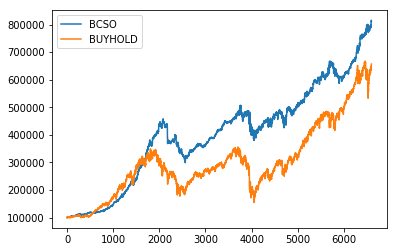

In [172]:
comparison.plot()

In [173]:
print("The return since 1993 with the BCSO strategy is: {}%".format(bcso_return))
print("The return since 1993 with the BCSO strategy is: {}%".format(bh_return))

The return since 1993 with the BCSO strategy is: 811%
The return since 1993 with the BCSO strategy is: 656%


# Notes and further analysis
While over ~45 years it appears that this strategy generates alpha - it seems to me when eyeballing the chart that the majority of the alpha was generated sometime around the 1800th day (too lazy to add date to X axis, apologies). I think a more valid test would be to generate a sequence of random trading periods - and then iterate across those testing and comparing the algorithms - before seeing how alpha is distributed. 

My intuition is that the alpha will be normally distributed with a mean very close to 0.

In [277]:
# This generates a list of tuples of random sets
def random_sets(num_sets,lower_limit,upper_limit):
    lst = []
    for i in range(num_sets):
        n1 = int(np.random.uniform(lower_limit,upper_limit,1))
        n2 = int(np.random.uniform(lower_limit,upper_limit,1))
        if n1 > n2:
            t = (n2,n1)
        else:
            t = (n1,n2)
        lst.append(t)
    return lst

In [278]:
# This runs the backtest agross the df as many times as necessary and returns the two lists of the differenct strategies
def random_backtest(df, num_tests):
    bcso_lst = []
    bh_lst = []
    
    set_intervals = random_sets(num_tests,df.index[0],df.index[-1])
    for i in range(num_tests):
        starting_cap = 100000
        df_BCSO = df.copy()
        df_BH = df.copy()
        df_BCSO = df_BCSO[set_intervals[i][0]:set_intervals[i][1]]
        df_BCSO.reset_index(drop=True,inplace=True)
        df_BH = df_BH[set_intervals[i][0]:set_intervals[i][1]]
        df_BH.reset_index(drop=True,inplace=True)
        BCSO = BCSO_strategy(df_BCSO,starting_cap)
        BUYHOLD = BUYHOLD_strategy(df_BH,starting_cap)
        BCSO_return = int(BCSO['fund'][-1:]/BCSO['fund'][0]*100)
        BH_return = int(BUYHOLD['fund'][-1:]/BCSO['fund'][0]*100)
        bcso_lst.append(BCSO_return)
        bh_lst.append(BH_return)
    
    return bcso_lst, bh_lst

In [ ]:
# This runs the backtest across 1000 random intervals in the SPY dataframe
bcso_returns,bh_returns = random_backtest(df,1000)
alphadf = pd.DataFrame({"bcso":bcso_returns,'bh':bh_returns})
alphadf['alpha'] = alphadf['bcso']-alphadf['bh']

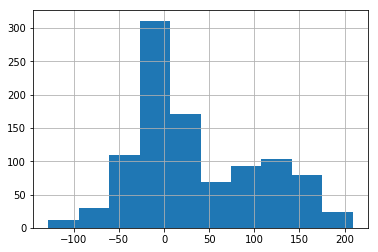

In [303]:
# This is the ditribution of alpha values
alphadf['alpha'].hist()

In [305]:
# This is the average alpha
alphadf.mean()['alpha']

34.991

# Damn... Cool!

It looks like you can generate ~35% alpha just by buying the close and selling the open. I'll be buying long term TQQQ calls every evening and selling them in the morning from now on!!!